Here we gonna build CharLM, which takes $k$ previous **words** (not characters) and predicts the next word **symbol by symbol**. The only problem here is to generate the vocabs.

In [1]:
import sys; sys.path += ['..', '../src']

In [2]:
% load_ext autoreload
% autoreload 2

In [3]:
import os
from itertools import islice

from src.vocab import Vocab

DATA_PATH = '../data/generated'
DUMMY_CHAR = 0
min_len = 100
max_len = 300

train_path = os.path.join(DATA_PATH, 'dostoevsky.tok')
train = open(train_path, 'r', encoding='utf-8').read().splitlines()
train = [s for s in train if len(s) < max_len]

vocab = Vocab.from_sequences(train, separator='')

train_idx = [[vocab.token2id[c] for c in s] for s in train]

In [4]:
# Let's currently use free GPU, which I've found on the server
%env CUDA_VISIBLE_DEVICES=3

env: CUDA_VISIBLE_DEVICES=3


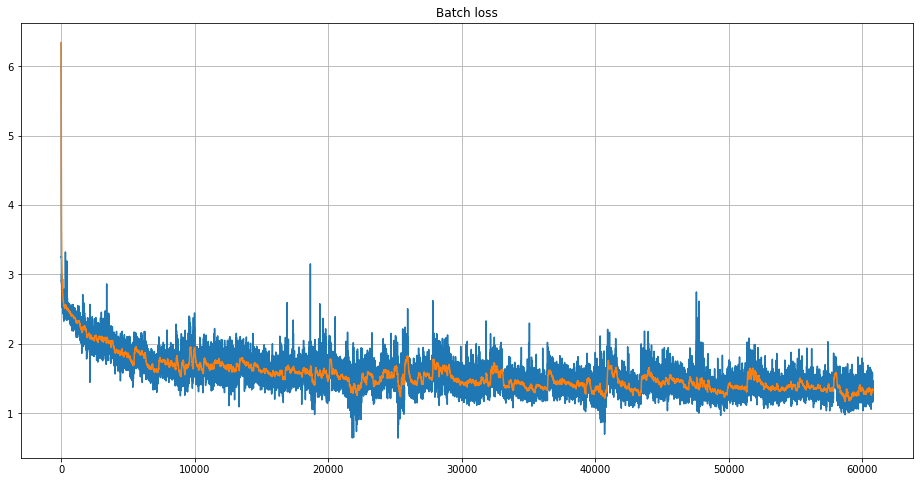

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
%matplotlib inline

import os
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.optim import Adam
from tqdm import tqdm; tqdm.monitor_interval = 0

from src.transformer.models import Transformer
from src.utils.char_batcher import CharBatcher
from src.utils.common import variable
import src.transformer.constants as constants

use_cuda = torch.cuda.is_available()
log_file_path = '../logs/lm.log'

# Let's clean log file
if os.path.exists(log_file_path): os.remove(log_file_path)

def reconstruction_criterion(vocab_size):
    ''' With PAD token zero weight '''
    weight = torch.ones(vocab_size)
    weight[constants.PAD] = 0

    return nn.CrossEntropyLoss(weight)

transformer_kwargs = {
    'n_head': 4,
    'n_layers': 4,
    'd_model': 256,
    'd_word_vec': 256,
    'd_inner_hid': 512
}
transformer = Transformer(5, len(vocab), max_len)
optimizer = Adam(transformer.get_trainable_parameters(), lr=1e-4)
criterion = reconstruction_criterion(len(vocab))

if use_cuda:
    transformer.cuda()
    criterion.cuda()

training_data = CharBatcher(train_idx, batch_size=8)
num_iters_done = 0
max_num_epochs = 1
loss_history = []

transformer.train()

try:
    for i in range(max_num_epochs):
        for seqs in tqdm(training_data, leave=False):
            # We feed encoder with sequences of a single dummy
            dummy_src = variable(torch.ones(len(seqs), 1).fill_(DUMMY_CHAR).long())
            trg = seqs[:, :-1]

            predictions = transformer(dummy_src, trg)
            loss = criterion(predictions, trg[:, 1:].contiguous().view(-1))
            loss_history.append(loss.data[0])

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if num_iters_done % 50 == 0:
                clear_output(True)
                plt.figure(figsize=[16,8])
                plt.title("Batch loss")
                plt.plot(loss_history)
                plt.plot(pd.DataFrame(np.array(loss_history)).ewm(span=100).mean())
                plt.grid()
                plt.show()
                
            num_iters_done += 1
except KeyboardInterrupt:
    pass

Let's run our transformer on news corpus. Inference is not that easy, because we are predicting word-by-word

In [27]:
torch.save(transformer.state_dict(), '../trained_models/char_transformer.pth')

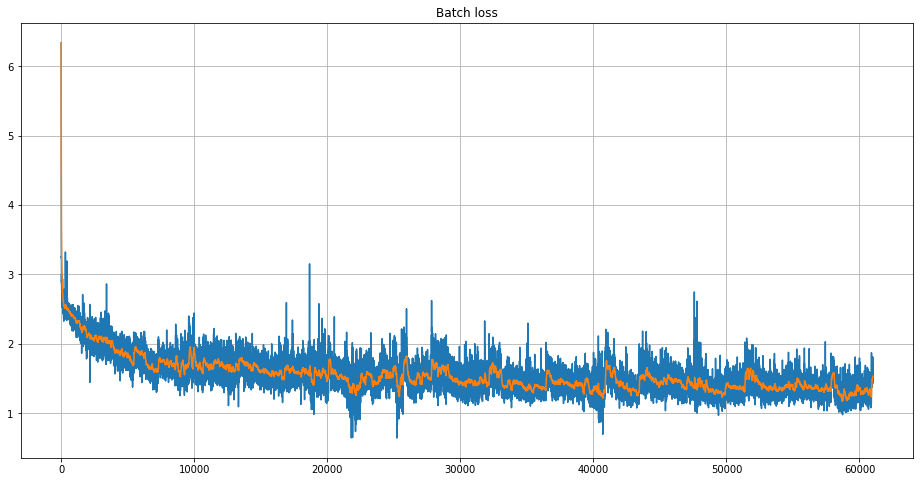

In [33]:
try:
    for i in range(max_num_epochs):
        for seqs in tqdm(training_data, leave=False):
            # We feed encoder with sequences of a single dummy
            dummy_src = variable(torch.ones(len(seqs), 1).fill_(DUMMY_CHAR).long())
            trg = seqs[:, :-1]

            predictions = transformer(dummy_src, trg)
            loss = criterion(predictions, trg[:, 1:].contiguous().view(-1))
            loss_history.append(loss.data[0])

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if num_iters_done % 50 == 0:
                clear_output(True)
                plt.figure(figsize=[16,8])
                plt.title("Batch loss")
                plt.plot(loss_history)
                plt.plot(pd.DataFrame(np.array(loss_history)).ewm(span=100).mean())
                plt.grid()
                plt.show()
                
            num_iters_done += 1
except KeyboardInterrupt:
    pass

In [34]:
from itertools import islice

from src.utils.data_utils import pad_to_longest, token_ids_to_sents
from src.utils.common import variable

SPACE_ID = vocab.token2id[' ']
news_path = os.path.join(DATA_PATH, 'news.ru.tok')
with open(news_path, encoding='utf-8') as f:
    news = list(islice(f, 100000))
news = [s for s in news if min_len < len(s) < max_len]
news = news[:2]
transformer.eval()
    
def get_subsentences(sent):
    words = sent.strip().split()
    subsents = [words[:i+1] for i in range(len(words) - 2)]
    subsents = [' '.join(s) for s in subsents]
    subsents = [[vocab.token2id[c] for c in s] for s in subsents]
    #subsents = pad_to_longest(subsents, volatile=True)
    
    return subsents

def next_words_to_translation(next_words, original_sentence):
    '''
        Constructs sentence from next words predictions
        For this we just take last word from each batch prediction
    '''
    next_words = token_ids_to_sents(next_words, vocab)
    next_words = [s.replace(' ', '') for s in next_words]
    original_words = original_sentence.split()
    translation = [w.strip() if w else original_words[i+1] for i,w in enumerate(next_words)]
    translation = ' '.join(translation)
    
    return translation


def translate(sentences):
    translations = []

    for sentence in sentences:
        next_words = []

        # Greedy decode for each subsentence until SPACE is met
        for seq in tqdm(get_subsentences(sentence)):
            next_word = []

            while len(next_word) < 20:
                curr_seq = seq + [SPACE_ID] + next_word
                dummy_src = variable(torch.ones(1, 1).fill_(DUMMY_CHAR).long(), volatile=True)
                trg = [constants.BOS] + curr_seq + [constants.EOS]
                trg = variable(torch.LongTensor(curr_seq).unsqueeze(0), volatile=True)
                probs = transformer(dummy_src, trg)
                predictions = torch.max(probs, dim=1)[1].data.cpu().numpy().tolist()
                next_char = predictions[-1]

                # Wow, we have encountered a space! Word generation is finished!
                if next_char == SPACE_ID: break

                next_word += [next_char]

            next_words.append(next_word)

        translation = next_words_to_translation(next_words, sentence)
        translations.append(translation)
        
    return sentences

In [42]:
translate(news[:2])

100%|██████████| 15/15 [00:00<00:00, 24.41it/s]


['Но мы начнем долгосрочное партнерство , которое облегчит вход &#91; на европейский рынок &#93; украинской продукции &quot; , - заявила в интервью УНИАН комиссар ЕС по вопросам торговли Сесилия Мальстрем .\n',
 'Евгений Цыганов в роли Ивана III в сериале &quot; София Палеолог &quot; Телеканал &quot; Россия 1 &quot;\n']

In [41]:
train[100]

'Месяца через два в окнах господского дома показалось прекрасное женское личико , сначала с заплаканными , а потом просто с прелестными голубыми глазками .'

In [40]:
translate([train[100]])

100%|██████████| 22/22 [00:01<00:00, 19.60it/s]


['Месяца через два в окнах господского дома показалось прекрасное женское личико , сначала с заплаканными , а потом просто с прелестными голубыми глазками .']